Training and predicting with `DeepForestDetector`
--

Train:
--

Here, we use `CustomDataModule` which inherits from `lightning.pytorch.LightningDataModule`

In [1]:
import lsnms

In [2]:
from tree_detection_framework.preprocessing.preprocessing import create_dataloader
from tree_detection_framework.preprocessing.derived_geodatasets import CustomDataModule
from tree_detection_framework.detection.detector import DeepForestDetector
from tree_detection_framework.detection.models import DeepForestModule

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Initialize a GeoDataModule instance
datamodule = CustomDataModule(
    train_raster_path="/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/emerald-point-ortho",
    train_vector_path="/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/crowns",
    val_raster_path="/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/emerald-point-ortho",
    val_vector_path="/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/crowns",
    output_res=0.2,
    vector_label_name="treeID",
    batch_size=2,
    size=512,
    stride=400,
)

# Setup the parameters dictionary
param_dict = {
    "backbone": "retinanet",
    "enable_checkpointing": True,
    "train": {"epochs": 3, "lr": 0.001},
    "num_classes": 1,
}

df_module = DeepForestModule(param_dict)
lightning_detector = DeepForestDetector(df_module)
# lightning_detector.train(datamodule)

Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


/ofo-share/repos-amritha/tree-detection-framework/tree_detection_framework/detection/models.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(t

Predict:
--

In [4]:
dataloader = create_dataloader(
    raster_folder_path="/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/emerald-point-ortho",
    chip_size=512,
    chip_stride=400,
    output_resolution=0.2,
    batch_size=3
)

2024-11-01 17:47:15,927 - INFO - Units = Units.PIXELS
2024-11-01 17:47:15,930 - INFO - Stride = 400


In [5]:
# deepforest_detector = DeepForestDetector()

# This model uses pretrained weights from DeepForest
outputs = lightning_detector.predict(dataloader)

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha ba

In [6]:
outputs

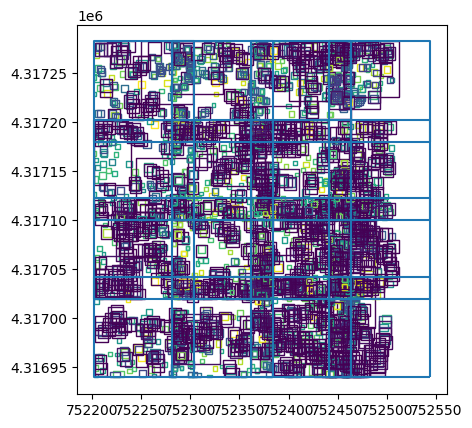

<Axes: >

In [7]:
outputs.plot(visualization_column='scores')

2024-11-01 17:49:32,119 - INFO - Bound have overlap, running across-region NMS


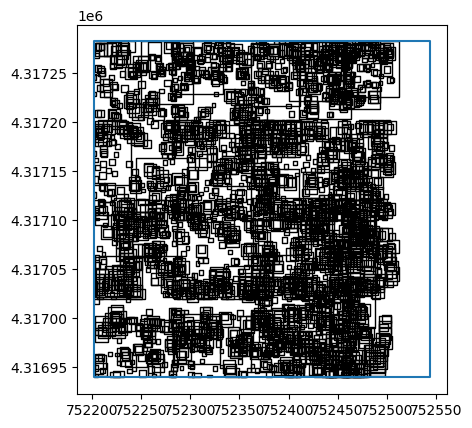

<Axes: >

In [10]:
from tree_detection_framework.postprocessing.postprocessing import multi_region_NMS

NMS_outputs = multi_region_NMS(outputs, confidence_column='scores')
NMS_outputs.plot()

In [7]:
len(outputs)

6

In [8]:
len(outputs[0])

3

In [9]:
from tree_detection_framework.detection.detector import LightningDetector

In [13]:
from tree_detection_framework.detection.region_detections import (
    RegionDetections,
    RegionDetectionsSet,
)

In [15]:
region_detections = []
for sample, prediction in zip(dataloader, outputs):
    # print("SAMPLE: ",sample)
    print("PREDICTION: ", prediction)
    image_bounds = LightningDetector.get_image_bounds_as_shapely(sample)[0]
    geospatial_bounds = LightningDetector.get_geospatial_bounds_as_shapely(
        sample
    )
    # prediction_geometry = DeepForestDetector.parse_deepforest_output(prediction)

    # # Extract the CRS of the first (only) element in the batch
    CRS = sample["crs"][0]

    # # Create the region detection
    # region_detection = RegionDetections(
    #     detection_geometries=prediction_geometry,
    #     data=prediction,
    #     pixel_prediction_bounds=image_bounds,
    #     geospatial_prediction_bounds=geospatial_bounds,
    #     input_in_pixels=True,
    #     CRS=CRS,
    # )
    # # Append to the list
    # region_detections.append(region_detection)


/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


PREDICTION:  [{'boxes': tensor([[2.2463e+02, 8.1770e+01, 2.5968e+02, 1.1828e+02],
        [1.6638e+02, 4.3276e+02, 1.9036e+02, 4.5953e+02],
        [1.6203e+02, 3.8245e+02, 1.8265e+02, 4.0361e+02],
        [2.0498e+02, 1.2914e+02, 2.4480e+02, 1.6923e+02],
        [2.5043e+02, 2.1531e+02, 2.8915e+02, 2.5328e+02],
        [4.2398e+02, 9.4514e+01, 4.6334e+02, 1.3322e+02],
        [3.6421e+02, 1.5618e+02, 4.0099e+02, 1.9326e+02],
        [1.3844e+02, 9.9619e+01, 1.8245e+02, 1.4565e+02],
        [4.5265e+02, 2.1697e+02, 5.1101e+02, 2.8664e+02],
        [4.0172e+02, 3.1316e+01, 4.2541e+02, 5.5233e+01],
        [2.7649e+02, 2.4177e+01, 3.0838e+02, 5.6679e+01],
        [1.6939e+02, 2.1698e+01, 1.9297e+02, 4.5439e+01],
        [3.4709e+02, 2.3331e+02, 3.7830e+02, 2.6352e+02],
        [2.6318e+02, 1.5373e+02, 2.8940e+02, 1.8045e+02],
        [3.8524e+02, 2.5299e+02, 4.2133e+02, 2.8912e+02],
        [0.0000e+00, 3.1308e+01, 1.9873e+01, 6.2160e+01],
        [4.1550e+02, 3.0845e+02, 4.4543e+02, 3.3

In [ ]:
RegionDetections()

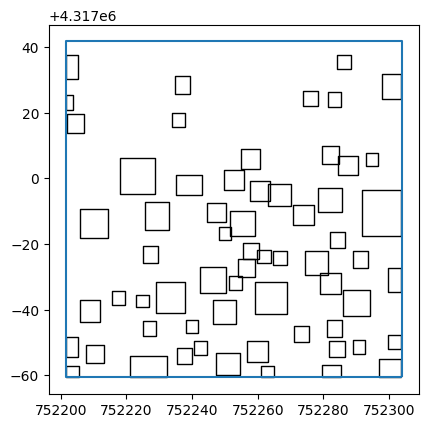

<Axes: >

In [6]:
predicted_regions.region_detections[0].plot()

In [7]:
predicted_regions.region_detections[0].detections

,xmin,ymin,xmax,ymax,label,score,geometry
0,224.0,81.0,259.0,118.0,Tree,0.650493,"POLYGON ((752253.308 4316955.549, 752253.308 4..."
1,166.0,432.0,190.0,459.0,Tree,0.637800,"POLYGON ((752239.508 4317025.749, 752239.508 4..."
2,162.0,382.0,182.0,403.0,Tree,0.637427,"POLYGON ((752237.908 4317015.749, 752237.908 4..."
3,204.0,129.0,244.0,169.0,Tree,0.610135,"POLYGON ((752250.308 4316965.149, 752250.308 4..."
4,250.0,215.0,289.0,253.0,Tree,0.604367,"POLYGON ((752259.308 4316982.349, 752259.308 4..."
...,...,...,...,...,...,...,...
58,121.0,224.0,158.0,268.0,Tree,0.273860,"POLYGON ((752233.108 4316984.149, 752233.108 4..."
59,22.0,212.0,64.0,256.0,Tree,0.243831,"POLYGON ((752214.308 4316981.749, 752214.308 4..."
60,83.0,279.0,136.0,335.0,Tree,0.239536,"POLYGON ((752228.708 4316995.149, 752228.708 4..."
61,308.0,262.0,343.0,295.0,Tree,0.192703,"POLYGON ((752270.108 4316991.749, 752270.108 4..."
